In [10]:
# Import Libraries
import pandas as pd
import catboost
import shap
import joblib
import matplotlib.pyplot as plt

In [11]:
# Initialize JavaScript for SHAP plots in the notebook
shap.initjs()

In [12]:
# Load the CatBoost model and test data file.

# Model pipeline
model_pipeline = joblib.load('Output Files\\Price Prediction model files\\predict_price_model_catBoost.joblib')

# Test data
X_test = pd.read_csv('Output Files\\Price Prediction model files\\X_test_for_CatBoost.csv')

In [13]:
# Check shape
X_test.shape

(1256, 46)

# SHAP (SHapley Additive exPlanations)

Since the SHAP TreeExplainer needs the raw model and not the full pipeline, we need to extract the raw CatBoost model from the pipeline and the processor also to transform the test data.

In [14]:
# Extract the raw CatBoost modle form the pipeline (the last step in pipeline)
catboost_model = model_pipeline.steps[-1][1]

In [15]:
# Extract the pre-processing part of the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Covered Area', 'Bedrooms', 'Bathrooms',
                                  'dist_to_csia_airport_km',
                                  'dist_to_thane_station_km',
                                  'dist_to_andheri_station_km',
                                  'dist_to_csmt_station_km',
                                  'dist_to_nariman_point_km',
                                  'dist_to_andheri_east_comm_km',
                                  'dist_to_marine_drive_km',
                                  'dist_to_navi_mumbai_airport_km',
                                  'dist_t...
                                                                              'construction',
                                                                              'Less '
                                                                              'than '
                                                                              '5 '
                                                                              'years',
                                                                              '5 '
                                                                              'to '
                                                                              '10 '
                                                                              'years',
                                                                              '10 '
                                                                              'to '
                                                                              '15 '
                                                                              'years',
                                                                              '15 '
                                                                              'to '
                                                                              '20 '
                                                                              'years',
                                                                              'Above '
                                                                              '20 '
                                                                              'years'],
                                                                             ['1.0',
                                                                              '2.0',
                                                                              '3.0',
                                                                              '3+'],
                                                                             ['Unfurnished',
                                                                              'Semi-Furnished',
                                                                              'Furnished'],
                                                                             ['Low '
                                                                              'rise '
                                                                              '(< '
                                                                              '5)',
                                                                              'Mid '
                                                                              'rise '
                                                                              '(5 '
                                                                              'to '
                                                                              '10)',
                                                                              'High '
                                                                              'rise '
       

In [16]:
# Transform the X_test data into the format the model was trained on
X_test_transformed = preprocessor.transform(X_test)

print(f"Shape of transformed test data: {X_test_transformed.shape}")

Shape of transformed test data: (1256, 54)


In [17]:
# Create a DataFrame with the correct post-transformation feature names
transformed_feature_names = preprocessor.get_feature_names_out()
X_test_transformed_df = pd.DataFrame(X_test_transformed, index=X_test.index, columns=transformed_feature_names)

# Sample
X_test_transformed_df.sample(4)  # This is what the model sees

,num__Covered Area,num__Bedrooms,num__Bathrooms,num__dist_to_csia_airport_km,num__dist_to_thane_station_km,num__dist_to_andheri_station_km,num__dist_to_csmt_station_km,num__dist_to_nariman_point_km,num__dist_to_andheri_east_comm_km,num__dist_to_marine_drive_km,...,remainder__Security,remainder__Water Storage,remainder__Vaastu Compliant,remainder__Visitor Parking,remainder__Intercom Facility,remainder__Maintenance Staff,remainder__Internet/Wi-Fi Connectivity,remainder__DTH Television Facility,remainder__Piped Gas,remainder__Jogging and Strolling Track
1010,0.109426,-0.054414,-0.254886,-1.179562,0.414748,-1.077753,-0.629002,-0.634667,-1.129411,-0.637551,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1152,-0.316564,-0.054414,-0.254886,0.586954,-2.100959,0.555053,0.722166,0.735649,0.501028,0.737412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,0.508791,1.005182,0.814912,-0.304476,-0.216601,-0.697912,0.147039,0.134070,-0.637329,0.125900,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
529,0.820719,1.005182,0.814912,-0.226523,1.722657,0.150994,-1.540254,-1.549784,0.159118,-1.546376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate SHAP values:

In [18]:
# Create a SHAP TreeExplainer with the extracted CatBoost model
explainer = shap.TreeExplainer(catboost_model)

# Calculate SHAP values on the TRANSFORMED test data
shap_values = explainer.shap_values(X_test_transformed)

print("SHAP values calculated successfully.")

SHAP values calculated successfully.


#### Plot 1: Summary plot (Global Importance)

--- SHAP Summary Plot: Global Feature Importance ---


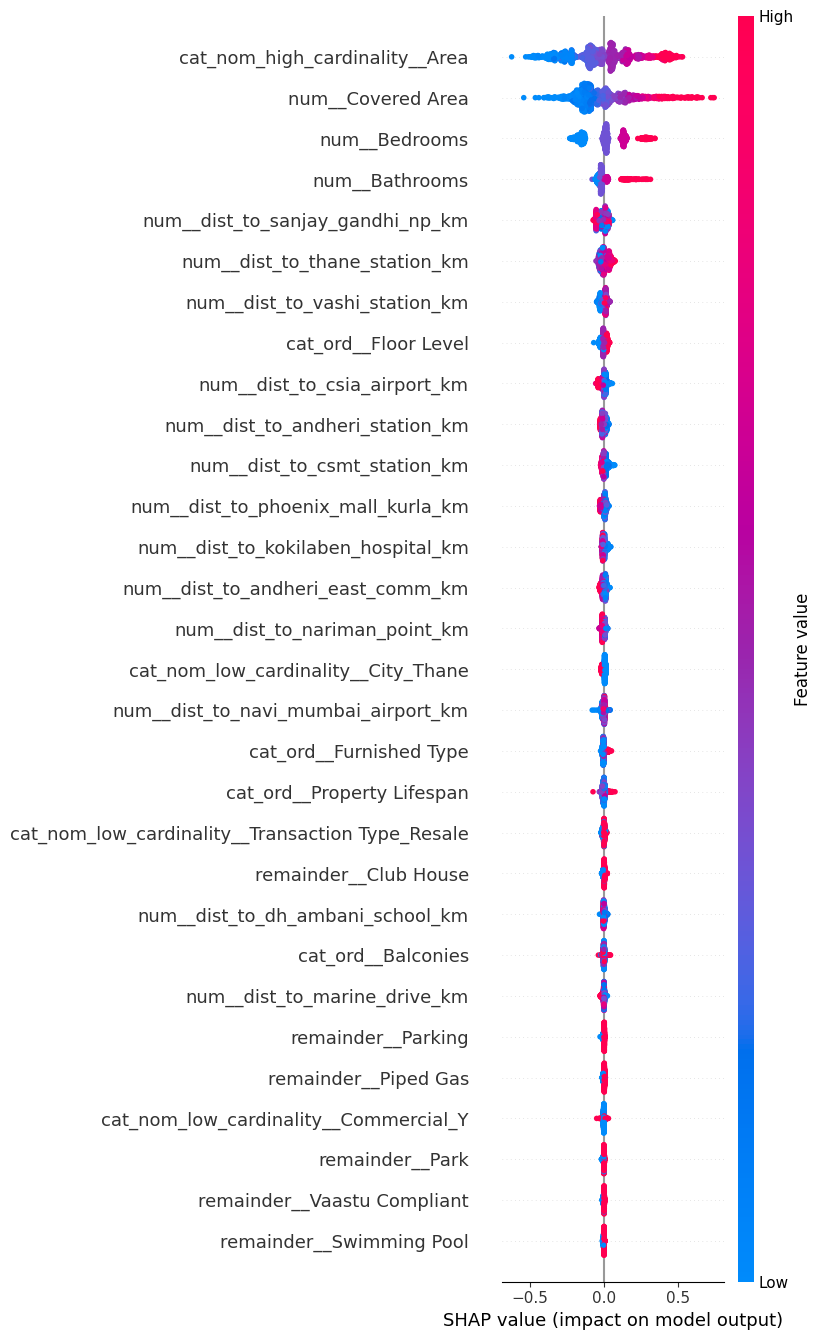

In [19]:
print("--- SHAP Summary Plot: Global Feature Importance ---")
shap.summary_plot(shap_values, X_test_transformed_df, max_display=30)

#### Plot 2: Dependence Plots


Dependence Plot for 'cat_nom_high_cardinality__Area':


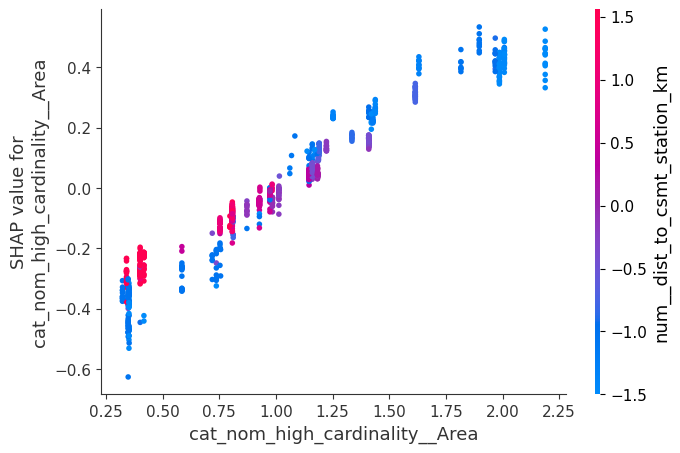


Dependence Plot for 'num__Covered Area':


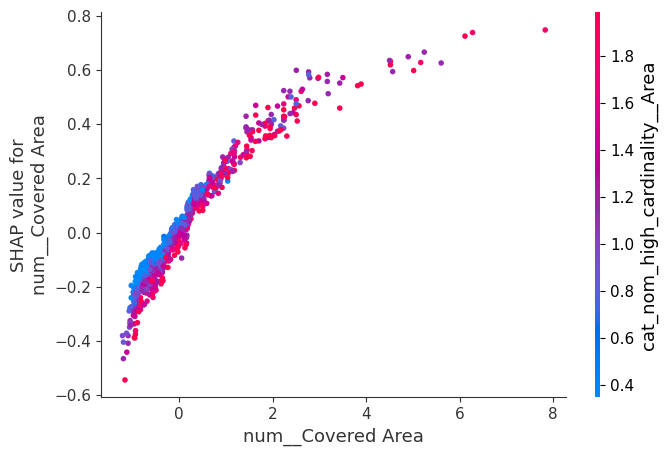


Dependence Plot for 'num__Bedrooms':


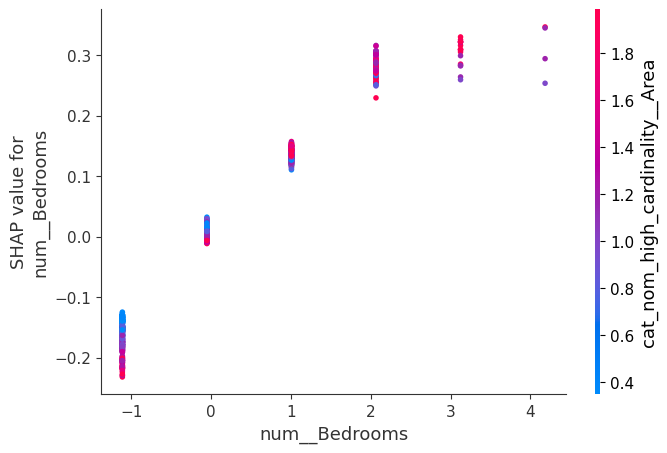


Dependence Plot for 'num__Bathrooms':


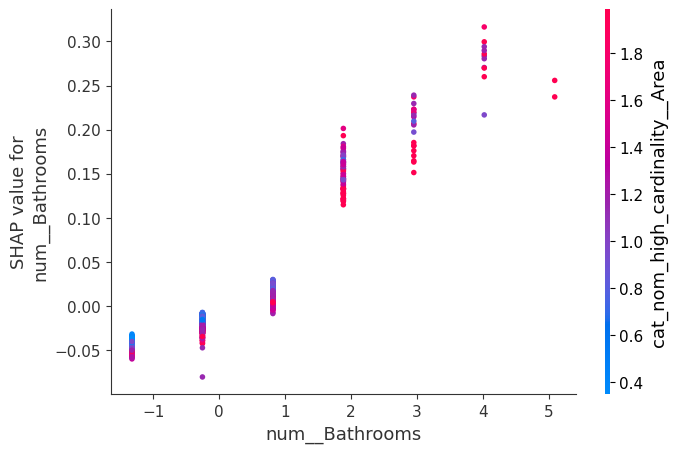

In [20]:
# Extract the top 4 feature names from the summary plot's ordering
mean_abs_shap = abs(shap_values).mean(0)
top_feature_indices = mean_abs_shap.argsort()[-4:][::-1]
top_features = X_test_transformed_df.columns[top_feature_indices]

for feature in top_features:
    print(f"\nDependence Plot for '{feature}':")
    shap.dependence_plot(feature, shap_values, X_test_transformed_df)

#### Plot 3: Force plot

In [21]:
# Select the instance to explain (e.g., the first property in X_test)
instance_index = 0
expected_value = explainer.expected_value
instance_shap_values = shap_values[instance_index, :]

# Use the TRANSFORMED features to match the dimensions of the SHAP values.
instance_features = X_test_transformed_df.iloc[instance_index, :]

shap.force_plot(expected_value, instance_shap_values, instance_features)

Original price of the property at index 0 of test data was 0.94 Crores.